<a href="https://colab.research.google.com/github/Mkhan2317/Pairs_Trading/blob/main/Pairs_Trading_in_S%26P_500_Cointegration_%26_Distance_Based_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strategy details



This strategy is based on the following paper:
Examining Pairs Trading Profitability

Link to reference: https://economics.yale.edu/sites/default/files/2024-05/Zhu_Pairs_Trading.pdf

The paper tries to examine the traditional pairs trading. The strategy is based on the mean-reverting property of the spread between two stocks. The strategy is based on the following steps:

1. Find a pair of stocks that are cointegrated.
2. Calculate the spread between the two stocks.
3. Calculate the z-score of the spread.
4. If the z-score is above a certain threshold, go short on the spread.
5. If the z-score is below a certain threshold, go long on the spread.
6. Exit the position when the z-score is close to zero.

There are different ways to find the pairs of stocks that are cointegrated. The paper uses the traditinal Eucasian distance method. The paper also mentioned some other methods like the two-step Engle-Granger method, the PCA method, and the clustering method.

In this notebook, I will use the Eucasian distance method to find the pairs of stocks that are cointegrated. I will then implement the pairs trading strategy based on the above steps.

In [ ]:
# Collect the list of the S&P 500 companies from Wikipedia and save it to a file
import os
import requests
import pandas as pd

# Get the list of S&P 500 companies from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)
html = response.content
df = pd.read_html(html, header=0)[0]

tickers = df['Symbol'].tolist()
# tickers.append('^GSPC')

In [ ]:
# Load the data from yahoo finance
# import os
import yfinance as yf

def load_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2005-01-01', end='2023-12-31')

        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')
    df['date'] = df.index

    if len(df) == 0:
        os.remove(file_name)
        return None

    return df


In [ ]:
holder = []
ticker_with_data = []
for symbol in tickers:
    df = load_data(symbol)
    if df is not None:
        holder.append(df)
        ticker_with_data.append(symbol)

tickers = ticker_with_data[:]

print (f'Loaded data for {len(tickers)} companies')


ERROR:yfinance:$BRK.B: possibly delisted; no timezone found
ERROR:yfinance:$BF.B: possibly delisted; no price data found  (1d 2005-01-01 -> 2023-12-31)
ERROR:yfinance:$GEV: possibly delisted; no price data found  (1d 2005-01-01 -> 2023-12-31) (Yahoo error = "Data doesn't exist for startDate = 1104555600, endDate = 1703998800")
ERROR:yfinance:$SW: possibly delisted; no price data found  (1d 2005-01-01 -> 2023-12-31) (Yahoo error = "Data doesn't exist for startDate = 1104555600, endDate = 1703998800")
ERROR:yfinance:$SOLV: possibly delisted; no price data found  (1d 2005-01-01 -> 2023-12-31) (Yahoo error = "Data doesn't exist for startDate = 1104555600, endDate = 1703998800")


Loaded data for 498 companies


In [ ]:
# Find cointegrated pairs in the holder
from statsmodels.tsa.stattools import coint
import numpy as np
import itertools


In [ ]:
# Keep the "close" and "open" column only
holder = [df[['Close', 'Open']] for df in holder]

# Devide all the prices by the first close price to normalize the data
normalized_holder = []

for i in range(len(holder)):
    df = holder[i].copy()
    normalizer = df['Close'].iloc[0]
    df['Close'] /= normalizer
    df['Open'] /= normalizer
    normalized_holder.append(df)

In [ ]:
# Show the head of the first dataframe
normalized_holder[0].head()

,Close,Open
Date,,
2005-01-03 00:00:00-05:00,1.000000,0.997209
2005-01-04 00:00:00-05:00,0.991869,1.000000
2005-01-05 00:00:00-05:00,0.979733,0.991505
2005-01-06 00:00:00-05:00,0.988592,0.981553
2005-01-07 00:00:00-05:00,0.998786,0.989077


In [ ]:
# Keep stocks that have data for the whole period
normalized_holder = [df for df in normalized_holder if len(df) == len(normalized_holder[0])]
tickers = [ticker for df, ticker in zip(normalized_holder, tickers)]

# Show the number of stocks that have data for the whole period
print(f'Number of stocks that have data for the whole period: {len(tickers)}')

Number of stocks that have data for the whole period: 394


# Split the data into training and testing

I will split the data into training and testing. I will use the training data to find the pairs of stocks that are cointegrated. I will then use the testing data to implement the pairs trading strategy. I will use the data from 2005 to 2019 for training and the data from 2019 to 2023 for testing.

In [ ]:
# Split the data into training and testing sets for each stock
training_data = [df[df.index.year < 2019] for df in normalized_holder]
testing_data = [df[df.index.year >= 2019] for df in normalized_holder]

# Show the rows of the first training dataframe and the first testing dataframe
training_data[0].shape, testing_data[0].shape

((3523, 2), (1258, 2))

In [ ]:
# Calculate the Euclidean distance between each pair of stocks, add a progress bar
distance_matrix = np.zeros((len(tickers), len(tickers)))
for i, j in itertools.product(range(len(tickers)), repeat=2):
    distance_matrix[i, j] = np.sqrt(np.sum((training_data[i]['Close'] - training_data[j]['Close']) ** 2))
    # Progress bar
    print(f'\r{i + 1}/{len(tickers)}', end='')


394/394

In [ ]:
# Show the distance matrix
distance_matrix

array([[  0.        , 300.98629273,  19.32567687, ...,  88.36970359,
         51.73644385,  56.54203804],
       [300.98629273,   0.        , 299.46660174, ..., 227.99630622,
        347.13590898, 356.27791475],
       [ 19.32567687, 299.46660174,   0.        , ...,  81.61516643,
         56.91701448,  63.01595347],
       ...,
       [ 88.36970359, 227.99630622,  81.61516643, ...,   0.        ,
        135.80457616, 142.16086225],
       [ 51.73644385, 347.13590898,  56.91701448, ..., 135.80457616,
          0.        ,  23.51526466],
       [ 56.54203804, 356.27791475,  63.01595347, ..., 142.16086225,
         23.51526466,   0.        ]])

In [ ]:
# Find the top 50 pairs of stocks with the smallest distance, excluding pairs of the same stock and distance 0
top_pairs = []
for i in range(len(tickers)):
    for j in range(i + 1, len(tickers)):
        if i != j and distance_matrix[i, j] != 0:
            top_pairs.append((tickers[i], tickers[j], distance_matrix[i, j]))

top_pairs = sorted(top_pairs, key=lambda x: x[2])[:50]

# Show top_pairs
top_pairs

[('DUK', 'FAST', 4.256926770794014),
 ('ALLE', 'LNT', 4.652434549620496),
 ('AMCR', 'CARR', 5.736515136212853),
 ('FAST', 'GIS', 5.900064633655689),
 ('GIS', 'MET', 6.4694096307259),
 ('ATO', 'GIS', 6.541573577154068),
 ('PAYX', 'RL', 7.054729710643872),
 ('MTD', 'PLD', 7.158300415446705),
 ('ATO', 'MET', 7.679285184186959),
 ('DUK', 'GIS', 7.878658812445894),
 ('FAST', 'MET', 8.287267613471082),
 ('GD', 'LULU', 8.296225298664613),
 ('ALGN', 'DHI', 8.759024671554089),
 ('STZ', 'HST', 9.231333258575253),
 ('DUK', 'MET', 9.260109070284113),
 ('FAST', 'MLM', 9.29747057083167),
 ('CEG', 'RTX', 9.439772710545501),
 ('GEHC', 'HIG', 9.440703621922884),
 ('DHI', 'HLT', 9.557382672983172),
 ('FMC', 'PAYX', 9.750366678724912),
 ('CAG', 'COO', 9.861491640115315),
 ('ATO', 'FAST', 9.917846819843634),
 ('HCA', 'LII', 9.935475926093943),
 ('PCAR', 'RL', 9.976476290995443),
 ('AVGO', 'EMR', 10.036222905397688),
 ('BWA', 'AVGO', 10.288307366595195),
 ('GOOG', 'NSC', 10.291910698175215),
 ('DUK', 'MLM'

In [ ]:
# Show the close prices of the first pair of stocks MMM and ABNB
import matplotlib.pyplot as plt

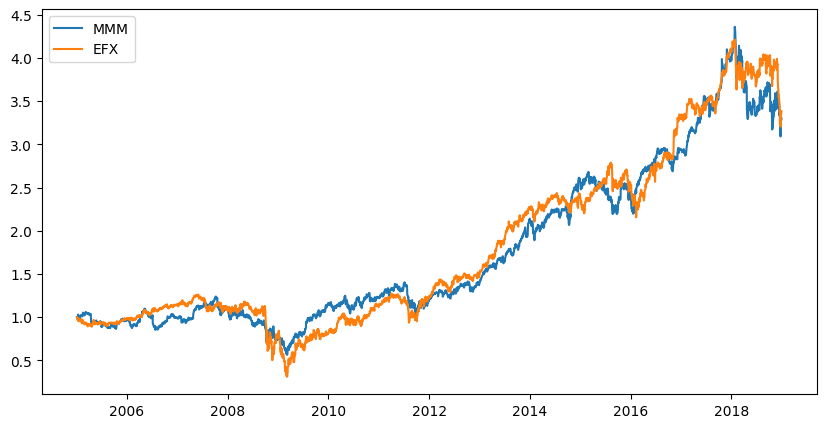

In [ ]:
# Plot the close prices of the first pair of stocks
i, j, _ = top_pairs[40]
i = tickers.index(i)
j = tickers.index(j)

plt.figure(figsize=(10, 5))
plt.plot(training_data[i]['Close'], label=tickers[i])
plt.plot(training_data[j]['Close'], label=tickers[j])
plt.legend()
plt.show()

In [ ]:
# For each pair of stocks, calculate spread = stock1 - stock2
spread = [testing_data[tickers.index(i)]["Close"] - testing_data[tickers.index(j)]["Close"] for i, j, _ in top_pairs]

# Show the head of the first spread
spread[0].head()

,Close
Date,
2019-01-02 00:00:00-05:00,-0.008634
2019-01-03 00:00:00-05:00,-0.003031
2019-01-04 00:00:00-05:00,-0.006288
2019-01-07 00:00:00-05:00,-0.005080
2019-01-08 00:00:00-05:00,-0.008534


In [ ]:
# Find the spread for the training data
spread_training = [training_data[tickers.index(i)]["Close"] - training_data[tickers.index(j)]["Close"] for i, j, _ in top_pairs]

# Find the standard deviation of the spread for each pair of stocks
std_spread = [np.std(s) for s in spread_training]

In [ ]:
# Generate the signals for each pair based on if the absolute value of spread is greater than 2 standard deviation
# If the spread is greater than 2 standard deviation, the signal is 1
# If the spread is less than -2 standard deviation, the signal is -1
# Otherwise, the signal is 0
signals = [np.where(s > 2 * std, 1, np.where(s < -2 * std, -1, 0)) for s, std in zip(spread, std_spread)]

In [ ]:
# For each pair, calculate the daily return of the strategy
# If the signal is 1, then short the first stock and long the second stock, hold the position until the spread is 0, then calculate the return for this trade
# If the signal is -1, then long the first stock and short the second stock, hold the position until the spread is 0, then calculate the return foer this trade
# If the signal is 0, then do nothing
returns = []
for i, j, _ in top_pairs:
    signal = signals[top_pairs.index((i, j, _))]
    i_index = tickers.index(i)
    j_index = tickers.index(j)
    returns.append([])

    for k in range(len(signal)):
        return_ = 0
        # If the signal is 1 and the previous signal is not 1, then short the first stock and long the second stock
        if signal[k] == 1 and (k == 0 or signal[k - 1] != 1):
            # Exit the position when the spread is less than or equal to 0
            exit = k + np.argmax(spread[top_pairs.index((i, j, _))][k:] <= 0)
            # Calculate the return of the trade, open at next day open price and close at exit day close price
            # Handle the case when the exit is the last day of the data
            if exit == len(spread[top_pairs.index((i, j, _))]) - 1:
                return_ = (testing_data[j_index]['Close'].iloc[-1] / testing_data[j_index]['Open'].iloc[k+1] - 1) - (testing_data[i_index]['Close'].iloc[-1] / testing_data[i_index]['Open'].iloc[k+1] - 1)
            else:
                return_ = (testing_data[j_index]['Close'].iloc[exit+1] / testing_data[j_index]['Open'].iloc[k+1] - 1) - (testing_data[i_index]['Close'].iloc[exit+1] / testing_data[i_index]['Open'].iloc[k+1] - 1)
            # Change the type of return_ to float
            return_ = float(return_)
            print(f'{i} {j} {k} {exit} {return_}')
        # If the signal is -1 and the previous signal is not -1, then long the first stock and short the second stock
        elif signal[k] == -1 and (k == 0 or signal[k - 1] != -1):
            # Exit the position when the spread is greater than or equal to 0
            exit = k + np.argmax(spread[top_pairs.index((i, j, _))][k:] >= 0)
            # Calculate the return of the trade, open at next day open price and close at exit day close price
            # Handle the case when the exit is the last day of the data
            if exit == len(spread[top_pairs.index((i, j, _))]) - 1:
                return_ = (testing_data[i_index]['Close'].iloc[-1] / testing_data[i_index]['Open'].iloc[k] - 1) - (testing_data[j_index]['Close'].iloc[-1] / testing_data[j_index]['Open'].iloc[k] - 1)
            else:
                return_ = (testing_data[i_index]['Close'].iloc[exit+1] / testing_data[i_index]['Open'].iloc[k+1] - 1) - (testing_data[j_index]['Close'].iloc[exit+1] / testing_data[j_index]['Open'].iloc[k+1] - 1)
            # Change the type of return_ to float
            return_ = float(return_)
            print(f'{i} {j} {k} {exit} {return_}')

        returns[-1].append(return_)

    print(f'\r{top_pairs.index((i, j, _)) + 1}/{len(top_pairs)}', end='')



DUK FAST 550 550 0.0038346133994495712
DUK FAST 961 961 -0.004242016645715996
DUK FAST 973 973 -0.03192304374720856
DUK FAST 1011 1011 -0.0031981713234515707
DUK FAST 1019 1019 -0.03337496109596716
DUK FAST 1093 1093 0.012254073372422347
DUK FAST 1103 1103 0.021578241950013455
DUK FAST 1105 1105 0.003384586424083791
DUK FAST 1123 1123 0.01075819586975213
DUK FAST 1126 1126 -0.003108019510589699
DUK FAST 1129 1129 0.019141314252341224
DUK FAST 1132 1132 -0.001509468510465739
DUK FAST 1144 1144 0.022950046643031796
DUK FAST 1180 1180 -0.01810282308214317
DUK FAST 1208 1208 0.06673763312880665
DUK FAST 1219 1219 -0.0006815593133872033
DUK FAST 1226 1226 -0.009837978305835327
1/50ALLE LNT 302 381 0.010162907889961215
ALLE LNT 416 416 0.0007150105602719004
ALLE LNT 421 421 -0.0014949049921288982
ALLE LNT 428 428 0.0011903547616587407
ALLE LNT 430 430 0.0011420922374345555
ALLE LNT 455 455 -0.00032020965529033774
ALLE LNT 461 461 -0.00022358656644339003
ALLE LNT 471 471 0.0028468144730242617

In [ ]:
# Calculate the cumulative return of the strategy for each pair using cumsum
cumulative_returns = [np.cumsum(r) for r in returns]

# How many pairs have a non zero cumulative return?
non_zero_cumulative_returns = [r[-1] for r in cumulative_returns if r[-1] != 0]
print(f'Number of pairs that have a non zero cumulative return: {len(non_zero_cumulative_returns)}')


Number of pairs that have a non zero cumulative return: 49


In [ ]:
# Calculate the sharpe ratio of the strategy for each pair excluding pairs that have a cumulative return of 0
sharpe_ratios = [np.mean(r) / np.std(r) * np.sqrt(252) for r in returns if np.std(r) != 0]

# Show the sharpe ratios with the corresponding pairs
sharpe_ratios_pairs = [(i, j, r) for (i, j, _), r in zip(top_pairs, sharpe_ratios)]

# Sort the pairs by sharpe ratio
sharpe_ratios_pairs = sorted(sharpe_ratios_pairs, key=lambda x: x[2], reverse=True)

sharpe_ratios_pairs

[('GOOG', 'NSC', 2.70557854585021),
 ('CTVA', 'EMR', 2.666401341093636),
 ('ALGN', 'GOOG', 2.634055826912702),
 ('MTD', 'PLD', 2.414309592111251),
 ('GEN', 'NI', 2.1945195729465894),
 ('GEHC', 'HIG', 2.1815522011649113),
 ('BKR', 'PCAR', 2.0311585870428996),
 ('PAYX', 'RL', 1.9882150553048794),
 ('CAH', 'LVS', 1.9772362485690127),
 ('CAT', 'LIN', 1.9618250653195852),
 ('GOOG', 'HBAN', 1.899304986221331),
 ('LII', 'PANW', 1.6928874085212775),
 ('DHI', 'HLT', 1.6540346668754229),
 ('CAG', 'COO', 1.6293609048683861),
 ('FAST', 'MET', 1.6125733317075155),
 ('CTVA', 'HST', 1.5866725473929237),
 ('ATO', 'MET', 1.5036988596448024),
 ('GOOG', 'CHRW', 1.503011335805778),
 ('STZ', 'HST', 1.4969744876067668),
 ('GIS', 'MET', 1.4557308279818677),
 ('DUK', 'MLM', 1.3854253744464993),
 ('PAYX', 'QCOM', 1.3490077111356729),
 ('DUK', 'GEHC', 1.3144659809479824),
 ('KLAC', 'PTC', 1.1917293852319426),
 ('AVGO', 'EMR', 1.1663457174039629),
 ('FAST', 'GIS', 1.1457382557262152),
 ('ALGN', 'DHI', 1.10319033

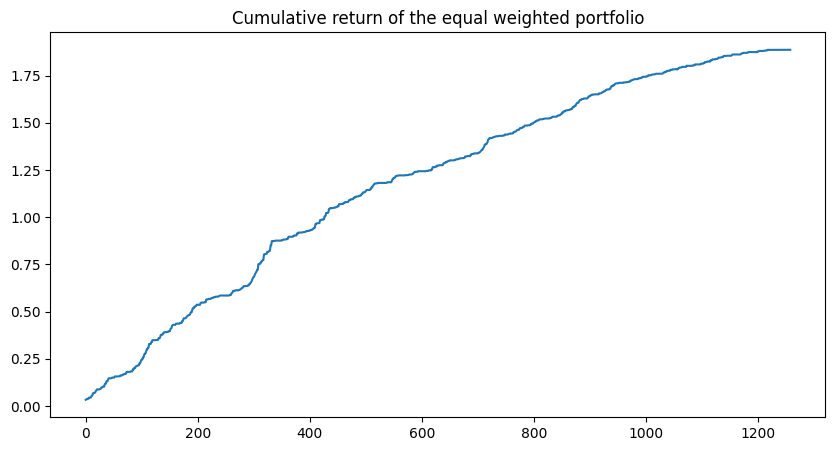

Sharpe ratio of the equal weighted portfolio: 0.9701685465559297


In [ ]:
# Calculate the sharpe ratio of a equal weighted portfolio

cumulative_returns_portfolio = np.sum(cumulative_returns, axis=0)/50
sharpe_ratio_portfolio = np.mean(cumulative_returns_portfolio) / np.std(cumulative_returns_portfolio) /np.sqrt(5)

# Draw the cumulative return of the equal weighted portfolio
plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns_portfolio)
plt.title('Cumulative return of the equal weighted portfolio')
plt.show()

print(f'Sharpe ratio of the equal weighted portfolio: {sharpe_ratio_portfolio}')

# Comments

This is a simple implementation of the pairs trading strategy. There are many ways to improve the strategy. For example, we can use machine learning models to predict the spread between the two stocks. We can also use more sophisticated methods to find the pairs of stocks that are cointegrated. But the results of this simple implementation are already promising.

# Another implementation using the two-step Engle-Granger method

Here is another implementation of the pairs trading strategy using the two-step Engle-Granger method.

For this implementation, I did not explicitly separate the training and testing data. I used the entire data to find the cointegrated pairs and then implemented the pairs trading strategy.

In [ ]:

def find_cointegrated_pairs(data):
    n = len(data)

    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))

    keys = range(n)
    pairs = list(itertools.combinations(keys, 2))

    for i, j in pairs:
        print(f'Finding cointegration for {tickers[i]} and {tickers[j]}')
        try:
            result = coint(data[i]['Close'], data[j]['Close'])
        except:
            print(f'Error in cointegration test for {tickers[i]} and {tickers[j]}')
            continue
        else:
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue

    return score_matrix, pvalue_matrix


In [ ]:
# Do not run this cell, load the data directly
score_matrix, pvalue_matrix = find_cointegrated_pairs(holder)

Finding cointegration for MMM and AOS
Finding cointegration for MMM and ABT
Finding cointegration for MMM and ABBV
Error in cointegration test for MMM and ABBV
Finding cointegration for MMM and ACN
Finding cointegration for MMM and ADBE
Finding cointegration for MMM and AMD
Finding cointegration for MMM and AES
Finding cointegration for MMM and AFL
Finding cointegration for MMM and A
Finding cointegration for MMM and APD
Finding cointegration for MMM and ABNB
Error in cointegration test for MMM and ABNB
Finding cointegration for MMM and AKAM
Finding cointegration for MMM and ALB
Finding cointegration for MMM and ARE
Finding cointegration for MMM and ALGN
Finding cointegration for MMM and ALLE
Error in cointegration test for MMM and ALLE
Finding cointegration for MMM and LNT
Finding cointegration for MMM and ALL
Finding cointegration for MMM and GOOGL
Finding cointegration for MMM and GOOG
Finding cointegration for MMM and MO
Finding cointegration for MMM and AMZN
Finding cointegration 

IndexError: list index out of range

In [ ]:
# Save the score and pvalue matrix
np.save('score_matrix.npy', score_matrix)
np.save('pvalue_matrix.npy', pvalue_matrix)

In [ ]:
# Read the score and pvalue matrix
score_matrix = np.load('score_matrix.npy')
pvalue_matrix = np.load('pvalue_matrix.npy')

In [ ]:

pairs = []
for i in range(len(tickers)):
    for j in range(i+1, len(tickers)):
        if pvalue_matrix[i, j] < 0.05:
            pairs.append((tickers[i], tickers[j]))

print (f'Found {len(pairs)} cointegrated pairs')



In [ ]:
# Print the top 100 cointegrated pairs with the lowest p-values
pairs.sort(key=lambda x: pvalue_matrix[tickers.index(x[0]), tickers.index(x[1])])
for pair in pairs[:100]:
    print(pair, pvalue_matrix[tickers.index(pair[0]), tickers.index(pair[1])])

In [ ]:
# Load the data for the top 100 cointegrated pairs
top_pairs = pairs[:100]
top_pairs_data = []
for pair in top_pairs:
    top_pairs_data.append((load_data(pair[0]), load_data(pair[1])))
    print(f'Loaded data for {pair[0]} and {pair[1]}')

In [ ]:
# For each df in the top_pairs_data, devide the close price by the first close price
for i, (df1, df2) in enumerate(top_pairs_data):
    top_pairs_data[i] = (df1['Close'] / df1['Close'].iloc[0], df2['Close'] / df2['Close'].iloc[0])

# Show the top_pairs_data[0]
print(top_pairs_data[0])

In [ ]:
# For each pair in the top_pairs_data, calculate the spread
spread_data = []
for df1, df2 in top_pairs_data:
    spread_data.append(df1 - df2)

# Show the spread_data[0]
print(spread_data[0])

In [ ]:
# Calculate the standard deviation of the spread for each pair
std_spread = []
for spread in spread_data:
    std_spread.append(np.std(spread))

# Show the std_spread[0]
print(std_spread[0])

In [ ]:
# Generate the signals for each pair based on if the absolute value of spread is greater than 2 standard deviation
# If the spread is greater than 2 standard deviation, the signal is 1
# If the spread is less than -2 standard deviation, the signal is -1
# Otherwise, the signal is 0
signals = []
for spread, std in zip(spread_data, std_spread):
    signals.append(np.where(spread > 2 * std, 1, np.where(spread < -2 * std, -1, 0)))

# Show the signals[0]
print(signals[0])


In [ ]:
# Calculate the daily return for each pair using close price
daily_return = [None] * len(top_pairs_data)
for i, (df1, df2) in enumerate(top_pairs_data):
    daily_return[i] = ((df1/df1.shift(1) - 1) , (df2/df2.shift(1) - 1))

# Show the daily_return[0]
print(daily_return[0])

In [ ]:
# For each pair, calculate the daily return of the strategy
# If the signal is 1, then short the first stock and long the second stock, hold the position until the spread is 0, then calculate the return for this trade
# If the signal is -1, then long the first stock and short the second stock, hold the position until the spread is 0, then calculate the return foer this trade
# If the signal is 0, then do nothing
daily_return_strategy = []
for i, (df1, df2) in enumerate(top_pairs_data):
    signal = signals[i]
    spread = spread_data[i]
    daily_return_strategy.append([0] * len(df1))
    for j in range(1, len(df1)):
        # If the signal is 1 and the previous signal is not 1, then short the first stock and long the second stock
        if signal[j] == 1 and signal[j-1] != 1:
            # Exit the position when the spread is less than or equal to 0
            k = j
            while k < len(df1) and spread[k] > 0:
                k += 1
            if k < len(df1):
                daily_return_strategy[i][j] = (df2[k+1]/df2[j+1] - 1) - (df1[k+1]/df1[j+1] - 1)
        # If the signal is -1 and the previous signal is not -1, then long the first stock and short the second stock
        elif signal[j] == -1 and signal[j-1] != -1:
            # Exit the position when the spread is greater than or equal to 0
            k = j
            while k < len(df1) and spread[k] < 0:
                k += 1
            if k < len(df1):
                daily_return_strategy[i][j] = (df1[k+1]/df1[j+1] - 1) - (df2[k+1]/df2[j+1] - 1)

# Show the daily_return_strategy[0]
print(daily_return_strategy[0])

In [ ]:
# Calculate the cumulative return for each pair using cumsum
cumulative_return = []
for daily_return_strat in daily_return_strategy:
    cumulative_return.append(np.cumsum(daily_return_strat))

# Show the cumulative_return[0]
print(cumulative_return[0])

In [ ]:
# Check the non zero cumulative return
for i, cum_return in enumerate(cumulative_return):
    if cum_return[-1] != 0:
        print(f'{top_pairs[i]}: {cum_return[-1]}')


In [ ]:
# calculate the sharpe ratio for each pair with non zero cumulative return
sharpe_ratio = []
for i, cum_return in enumerate(cumulative_return):
    if cum_return[-1] != 0:
        sharpe_ratio.append(np.mean(daily_return_strategy[i]) / np.std(daily_return_strategy[i]) * np.sqrt(252))

# Show the sharpe_ratio
for i, ratio in enumerate(sharpe_ratio):
    print(f'{top_pairs[i]}: {ratio}')


In [ ]:
# Calculate the sharpe ratio of a equal weighted portfolio
cumulative_returns_array = np.zeros(len(cumulative_return))
for i, cum_return in enumerate(cumulative_return):
    cumulative_returns_array[i] = cum_return[-1]

# drop the pairs that have zero cumulative return
cumulative_returns_array = cumulative_returns_array[cumulative_returns_array != 0]

print(cumulative_returns_array)

cumulative_returns_portfolio = np.sum(cumulative_returns_array, axis=0)/len(cumulative_returns_array)
sharpe_ratio_portfolio = np.mean(cumulative_returns_array) / np.std(cumulative_returns_array)

print(f'Sharpe ratio of the equal weighted portfolio: {sharpe_ratio_portfolio}')


# Some final thoughts
Through the two methods we implemented in this notebook, we can see that the pairs trading strategy is profitable after so many years. The distance method is not so flexiable compared to the Engle-Granger method because the long short ratio is fixed to 1:1. But the results are not so different.

There are some future work we can do to improve and explore the strategy:
1. We can adjust the long short ratio to see if the strategy is more profitable using the two step Engle-Granger method.
2. “Generalized pairs-trading”, or trading groups of stocks against other groups of stocks, is a natural extension of pairs-trading. A generalized pairs trading book, or statistical arbitrage book, consists of a collection of “pair trades” of stocks relative to the ETF (or, more generally, factors that explain the systematic stock returns). In some cases, an individual stock may be held long against a short position in ETF, and in others we would short the stock and go long the ETF. Due to netting of long and short positions, we expect that the net position in ETFs will represent a small fraction of the total holdings. The trading book will look therefore like a long/short portfolio of single stocks. We can use this idea to costruct a more flexible portfolio.